En este proyecto abordaremos la clasificación de incidencias de la herramienta ServiceNow, para lo cual antes de diseñar nuestro modelo necesitamos generar nuestro data set de entrenamiento, el cual no es simple, no solo es leer un data set de origen, si no que necesitaremos preparar nuestros datos. 

El flujo de trabajo general del proceso se puede dividir en varias subpartes. En la siguiente figura se muestra una descripción general de muy alto nivel.

![A diagram](https://github.com/novagenio/CognitivePV1/blob/main/images/workflow.png?raw=true)

El conjunto de datos se extrae directamente de un repositorio publico de ServiceNow. El preprocesamiento inicial de datos incluye la limpieza de datos (eliminación de duplicados, eliminación de filas vacías, eliminación de palabras vacías, etc.)
Los datos originales no estaban etiquetados y contenían solo las descripciones de los ticket. Dado que el enfoque seleccionado para este proyecto es la clasificación, necesitábamos algún mecanismo para convertir estos datos no etiquetados en datos etiquetados. 

Uno de los enfoques populares para esto es el modelado de las descripciones. El modelado de las descripciones nos permitira seleccionar las 5 categorías principales para nuestros datos, lo que nos ayudara a crear los datos etiquetados (categorías de incidentes).

Leemos los datos del fichero cvs. "No son datos extraidos de ServiceNow" son de un repositorio publico en Kaggle. 
Realizamos ELA y preprocesado

In [ ]:
# libraries

### https://github.com/pankajkishore/Cognitive-Project

import keras 
import numpy as np
from keras.preprocessing.text import Tokenizer
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten
from keras.models import Model
from tensorflow.keras.utils import to_categorical  # LGU
from keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
plt.style.use('ggplot')
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [ ]:
### Leemos los datos del dataset

### Nueva sección

Leemos los datos del dataset, mostramos, contamos categorias y definimos un target numerico por categoria

In [2]:
data = pd.read_csv('latest_ticket_data.csv')

In [3]:
data.head()

,Description,Category
0,hi since recruiter lead permission approve req...,Application
1,re expire days hi ask help update passwords co...,Application
2,verification warning hi has got attached pleas...,Application
3,please dear looks blacklisted receiving mails ...,Application
4,dear modules report report cost thank much reg...,Application


In [4]:
data.Category.value_counts()

Application         600
Database            600
Network             600
User Maintenance    600
Security            600
Name: Category, dtype: int64

In [5]:
data['target'] = data.Category.astype('category').cat.codes

In [6]:
data.head(500)

,Description,Category,target
0,hi since recruiter lead permission approve req...,Application,0
1,re expire days hi ask help update passwords co...,Application,0
2,verification warning hi has got attached pleas...,Application,0
3,please dear looks blacklisted receiving mails ...,Application,0
4,dear modules report report cost thank much reg...,Application,0
...,...,...,...
495,information user requested installation hello ...,Application,0
496,hi please issue assign thank best regards engi...,Application,0
497,unknown pipeline code hi add unknown pipeline ...,Application,0
498,setup form hello please two tickets thank kind...,Application,0


En Pandas, tenemos la libertad de agregar diferentes funciones cuando sea necesario, como función lambda, función de clasificación, etc. Podemos aplicar una función lambda tanto a las columnas como a las filas del marco de datos de Pandas.
EN este caso contaremos la palabras del campo descripción e incluiremos una etiqueta en el rango de palabras en que esta cada descripción (entre 0-100, 100-200, etc.)
Posteriormente agrupamos y revisamos la distribución del ranfo de palabras respecto a los registros de la muestra.

In [7]:
data['num_words'] = data.Description.apply(lambda x : len(x.split()))

In [9]:
bins=[0,50,75, np.inf]
data['bins']=pd.cut(data.num_words, bins=[0,100,300,500,800, np.inf], labels=['0-100', '100-300', '300-500','500-800' ,'>800'])

In [10]:
word_distribution = data.groupby('bins').size().reset_index().rename(columns={0:'counts'})

In [14]:
word_distribution.head()

,bins,counts
0,0-100,2817
1,100-300,162
2,300-500,15
3,500-800,2
4,>800,4


Text(0.5, 1.0, 'Word distribution per bin')

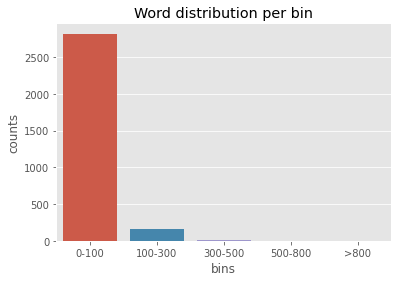

In [12]:
sns.barplot(x='bins', y='counts', data=word_distribution).set_title("Word distribution per bin")

Aqui vemos cada registro del dataset, con su descripción, categoria, el target definido, el numero de palabras que contine caa categoria y el rango en que esta el numero de palabras.

In [13]:
data.head()

,Description,Category,target,num_words,bins
0,hi since recruiter lead permission approve req...,Application,0,12,0-100
1,re expire days hi ask help update passwords co...,Application,0,140,100-300
2,verification warning hi has got attached pleas...,Application,0,14,0-100
3,please dear looks blacklisted receiving mails ...,Application,0,14,0-100
4,dear modules report report cost thank much reg...,Application,0,8,0-100


Asignamos el target a la variable **y**, la que usaremos más adelante en el modelo. Ojo con esto.

In [15]:
num_class = len(np.unique(data.Category.values))
y = data['target'].values

# Topic Modelling

Antes de darle caña al proceso, estas son algunas de las suposiciones que consideramos:
Elegimos la cantidad de descripciones con anticipación, incluso si no estamos seguros de cuáles son.
Cada documento se representa como una distribución por descripción.
Cada descripción se representa como una distribución sobre palabras.
Usamos** Wordnet de NLTK** para encontrar los significados de palabras, sinónimos, antónimos y más. Además, usamos **WordNetLemmatizer** para obtener la raíz de la palabra.
Luego leemos nuestro conjunto de datos línea por línea y preparamos cada línea para LDA y las almacenamos en una lista.

In [16]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import numpy as np
import pandas as pd
import re
import warnings

#Visualisation
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from IPython.display import display
#from mpl_toolkits.basemap import Basemap
from wordcloud import WordCloud, STOPWORDS

#nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [17]:
data['Description'] = data['Description'].astype(str)

In [18]:
data.head()

,Description,Category,target,num_words,bins
0,hi since recruiter lead permission approve req...,Application,0,12,0-100
1,re expire days hi ask help update passwords co...,Application,0,140,100-300
2,verification warning hi has got attached pleas...,Application,0,14,0-100
3,please dear looks blacklisted receiving mails ...,Application,0,14,0-100
4,dear modules report report cost thank much reg...,Application,0,8,0-100


In [19]:
type(data['Description'])

pandas.core.series.Series

In [20]:
data_description = data.Description.values

In [21]:
type(data_description)

numpy.ndarray

In [22]:
print(data_description)

['hi since recruiter lead permission approve requisitions makes please make thanks recruiter'
 're expire days hi ask help update passwords colleagues thank pm expire days importance high hi received about expiration please kindly help prolongation best regards pm expire days importance high dear expire days order change please follow steps prerequisites disable device credentials close active connected by cable machine note also follow steps detailed press ctrl alt delete same pops change item enter format enter enter newly chosen then re enter again submit displaying has changed os machine browse enter format enter gear icon top tight browser window enter enter newly chosen then re enter again save connected note complete resources granted once connected by cable browse tick want change after logging enter format enter log enter enter newly chosen then re enter again change clients suppliers about expire please touch person then communicate back encounter issues hesitate by accessing

In [23]:
#cv = # Initialize a CountVectorizer object: count_vectorizer
count_vec = CountVectorizer(stop_words="english", analyzer='word', 
                            ngram_range=(1, 1), max_df=1, min_df=1, max_features=None)

# convert text data into term-frequency matrix
data_description = count_vec.fit_transform(data_description)




tfidf_transformer = TfidfTransformer()

# convert term-frequency matrix into tf-idf
tfidf_matrix = tfidf_transformer.fit_transform(data_description)

# create dictionary to find a tfidf word each word
word2tfidf = dict(zip(count_vec.get_feature_names(), tfidf_transformer.idf_))

for word, score in word2tfidf.items():
    print(word, score)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


abnormal 8.313553664880422
abort 8.313553664880422
abroad 8.313553664880422
absent 8.313553664880422
absolutely 8.313553664880422
ac 8.313553664880422
accessibility 8.313553664880422
accident 8.313553664880422
accidental 8.313553664880422
accommodate 8.313553664880422
accomplish 8.313553664880422
accomplished 8.313553664880422
accountable 8.313553664880422
accrual 8.313553664880422
accurately 8.313553664880422
ace 8.313553664880422
achievable 8.313553664880422
acknowledging 8.313553664880422
acre 8.313553664880422
adapt 8.313553664880422
adaptors 8.313553664880422
adder 8.313553664880422
adhesive 8.313553664880422
adjacency 8.313553664880422
adjusted 8.313553664880422
administers 8.313553664880422
adv 8.313553664880422
advancement 8.313553664880422
advantageous 8.313553664880422
advantages 8.313553664880422
advertisement 8.313553664880422
advertising 8.313553664880422
advisors 8.313553664880422
advisory 8.313553664880422
affiliate 8.313553664880422
affiliated 8.313553664880422
afford 8

In [ ]:
term_frequency = count_vec.vocabulary_
type(term_frequency)

dict

In [ ]:
sorted_by_idf = np.argsort(tfidf_transformer.idf_)
feature_names = np.array(count_vec.get_feature_names())
print("Features with lowest idf:\n{}".format(
       feature_names[sorted_by_idf[:10]]))
print("\nFeatures with highest idf:\n{}".format(
       feature_names[sorted_by_idf[-10:]]))

Features with lowest idf:
['abnormal' 'pressed' 'presidential' 'preserving' 'presenting' 'preparer'
 'prepared' 'preparatory' 'premium' 'premier']

Features with highest idf:
['exits' 'exhibitor' 'exhibiting' 'exhaustion' 'exercises' 'exempt'
 'exclusive' 'excluding' 'developed' 'zip']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


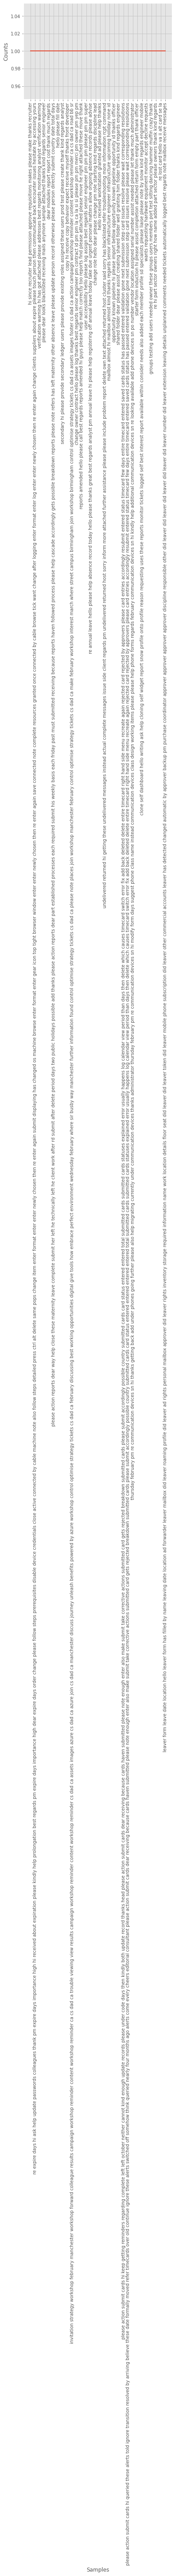

In [ ]:
count = nltk.FreqDist(data.Description.values)
count.plot(30)

In [ ]:
final_doc = data['Description']
all_documents = tuple(final_doc)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(all_documents)
print (tfidf_matrix.shape)
print(tfidf_matrix)

(3000, 5103)
  (0, 4576)	0.10299806622237614
  (0, 2668)	0.18254043930267794
  (0, 3274)	0.06031024879919189
  (0, 2670)	0.2860029411187468
  (0, 3820)	0.3645777109755145
  (0, 265)	0.23545400931874272
  (0, 3201)	0.26585087961564136
  (0, 2513)	0.1738031714611934
  (0, 3647)	0.729155421951029
  (0, 4178)	0.20563798743451187
  (0, 2101)	0.08626144127793878
  (1, 5096)	0.07020701992458687
  (1, 24)	0.04832694620759567
  (1, 2099)	0.048115143127618366
  (1, 2414)	0.03693953132530033
  (1, 1512)	0.0558517896006317
  (1, 414)	0.04064402016790579
  (1, 873)	0.063821035395235
  (1, 3210)	0.05022346699041275
  (1, 4675)	0.05687651451476529
  (1, 4461)	0.07020701992458687
  (1, 803)	0.04541252147836656
  (1, 2607)	0.030805974318114906
  (1, 2610)	0.05802964608186429
  (1, 121)	0.03577176428536712
  :	:
  (2999, 3393)	0.14769226069397964
  (2999, 3792)	0.1325768667774891
  (2999, 1636)	0.15168542549197145
  (2999, 1713)	0.08173432777498829
  (2999, 4769)	0.13005460702825805
  (2999, 2575)	0.099

LDA con Gensim
Primero, estamos creando un diccionario a partir de los datos, luego lo convertimos a una bolsa de palabras y guardamos el diccionario y el corpus para uso futuro.

In [ ]:
reindexed_data= data["Description"]

data_text = data[['Description']]
data_text['index'] = data_text.index
documents=data_text


print(len(documents))
print(documents[:5])

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk


def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

3000
                                         Description  index
0  hi since recruiter lead permission approve req...      0
1  re expire days hi ask help update passwords co...      1
2  verification warning hi has got attached pleas...      2
3  please dear looks blacklisted receiving mails ...      3
4  dear modules report report cost thank much reg...      4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
stemmer.stem('identified')

import nltk
nltk.download('wordnet')


doc_sample = documents[documents['index'] == 5].values[0][0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))


processed_docs = documents['Description'].map(preprocess)
processed_docs[:5]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
original document: 
['please', 'action', 'reports', 'dear', 'way', 'help', 'close', 'these', 'maternity', 'leave', 'complete', 'submit', 'her', 'left', 'he', 'technically', 'left', 'he', 'client', 'work', 'after', 'rd', 'submit', 'after', 'delete', 'period', 'days', 'two', 'public', 'holidays', 'possible', 'add', 'thanks', 'please', 'action', 'reports', 'dear', 'part', 'established', 'processes', 'each', 'required', 'submit', 'his', 'weekly', 'basis', 'each', 'friday', 'past', 'must', 'submitted', 'receiving', 'because', 'reports', 'haven', 'followed', 'process', 'please', 'help', 'cascade', 'accordingly', 'gets', 'possible', 'breakdown', 'reports', 'please', 'note', 'refers', 'has', 'left', 'maternity', 'other', 'absence', 'leave', 'please', 'update', 'person', 'record', 'otherwise', 'please', 'person', 'directly', 'submit', 'country', 'date', 'total', 'days']


 tokenized and le

0    [recruit, lead, permiss, approv, requisit, mak...
1    [expir, day, help, updat, password, colleagu, ...
2    [verif, warn, attach, address, best, regard, m...
3    [dear, look, blacklist, receiv, mail, anymor, ...
4    [dear, modul, report, report, cost, thank, reg...
Name: Description, dtype: object

In [ ]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 approv
1 lead
2 make
3 permiss
4 recruit
5 requisit
6 thank
7 access
8 activ
9 best
10 brows


In [ ]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[123]

[(9, 1), (92, 1), (220, 2), (224, 1)]

In [ ]:
#Preview Bag Of Words for our sample preprocessed document.
bow_doc_123 = bow_corpus[123]
for i in range(len(bow_doc_123)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_123[i][0], 
                                               dictionary[bow_doc_123[i][0]], 
bow_doc_123[i][1]))

Word 9 ("chang") appears 1 time.
Word 92 ("hello") appears 1 time.
Word 220 ("group") appears 2 time.
Word 224 ("account") appears 1 time.


In [ ]:
#TF-IDF
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.44601943199951827),
 (1, 0.36607583555040674),
 (2, 0.6096175946645763),
 (3, 0.54352694246033)]


In [ ]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=5, id2word=dictionary, passes=2, workers=2)

El siguiente paso fue encontrar 5 temas usando LDA. A continuación hay varios fragmentos de código para dar una breve descripción general del proceso.

In [ ]:
# Print the results
import pickle

# Here we can assign topic names to each topic list, you can specify the number of words you want to have shown (e.g num_words = 5)
result = lda_model.print_topics(num_topics=5, num_words=5)
print(result)

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

[(0, '0.037*"card" + 0.026*"regard" + 0.017*"event" + 0.015*"hello" + 0.014*"kind"'), (1, '0.026*"user" + 0.021*"send" + 0.019*"regard" + 0.018*"chang" + 0.016*"hello"'), (2, '0.031*"send" + 0.028*"regard" + 0.027*"hello" + 0.023*"card" + 0.021*"work"'), (3, '0.034*"card" + 0.028*"regard" + 0.026*"floor" + 0.023*"hello" + 0.022*"access"'), (4, '0.022*"send" + 0.020*"hello" + 0.019*"visitor" + 0.016*"issu" + 0.015*"leav"')]
Topic: 0 
Words: 0.037*"card" + 0.026*"regard" + 0.017*"event" + 0.015*"hello" + 0.014*"kind" + 0.014*"chang" + 0.013*"updat" + 0.013*"item" + 0.013*"detail" + 0.013*"assign"
Topic: 1 
Words: 0.026*"user" + 0.021*"send" + 0.019*"regard" + 0.018*"chang" + 0.016*"hello" + 0.014*"card" + 0.011*"client" + 0.011*"access" + 0.011*"enter" + 0.009*"best"
Topic: 2 
Words: 0.031*"send" + 0.028*"regard" + 0.027*"hello" + 0.023*"card" + 0.021*"work" + 0.019*"issu" + 0.016*"leaver" + 0.016*"connect" + 0.016*"access" + 0.014*"best"
Topic: 3 
Words: 0.034*"card" + 0.028*"regard" + 

In [ ]:

# put these in a file and name the topics
with open("lda_topics_result.txt", "w") as f:
    for s in result:
        f.write(str(s) +"\n")

Para obtener una mejor visualización de los temas, usamos pyLDAvis.
pyLDAvis está diseñado para ayudar a los usuarios a interpretar los temas en un modelo de tema que se ha ajustado a un corpus de datos de texto. El paquete extrae información de un modelo de tema LDA ajustado para informar una visualización interactiva basada en la web.

In [ ]:
# Visualize
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models
#import pyLDAvis.gensim
pyLDAvis.enable_notebook()


lda_display = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus,dictionary, sort_topics=True)
#pyLDAvis.gensim_models.prepare(ldamodel, doc_term_matrix, dictionary)
pyLDAvis.display(lda_display)

     |████████████████████████████████| 1.7 MB 3.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=1c916b731f0bf2e4dd17a4e6557f1d7c7898daef38032e5392b0c649cf5c4376
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
from collections import OrderedDict

data_lda = {i: OrderedDict(lda_model.show_topic(i,25)) for i in range(5)}

In [ ]:
import pandas as pd

df_lda = pd.DataFrame(data_lda)
print(df_lda.shape)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(68, 5)
(5, 68)


In [ ]:
df_lda

,card,regard,event,hello,kind,chang,updat,item,detail,assign,...,provid,disk,leav,phone,confidenti,look,matern,error,intend,return
0,0.037447,0.025583,0.016968,0.015240,0.014425,0.013806,0.013338,0.013276,0.012948,0.012512,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
1,0.013524,0.019059,0.000000,0.015545,0.008658,0.017877,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
2,0.023352,0.028376,0.000000,0.027358,0.010725,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
3,0.034297,0.028218,0.000000,0.023069,0.014687,0.000000,0.000000,0.000000,0.000000,0.010066,...,0.008594,0.008009,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
4,0.012253,0.014105,0.000000,0.019832,0.006725,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.015303,0.006914,0.006619,0.006599,0.006508,0.006414,0.00632,0.00615


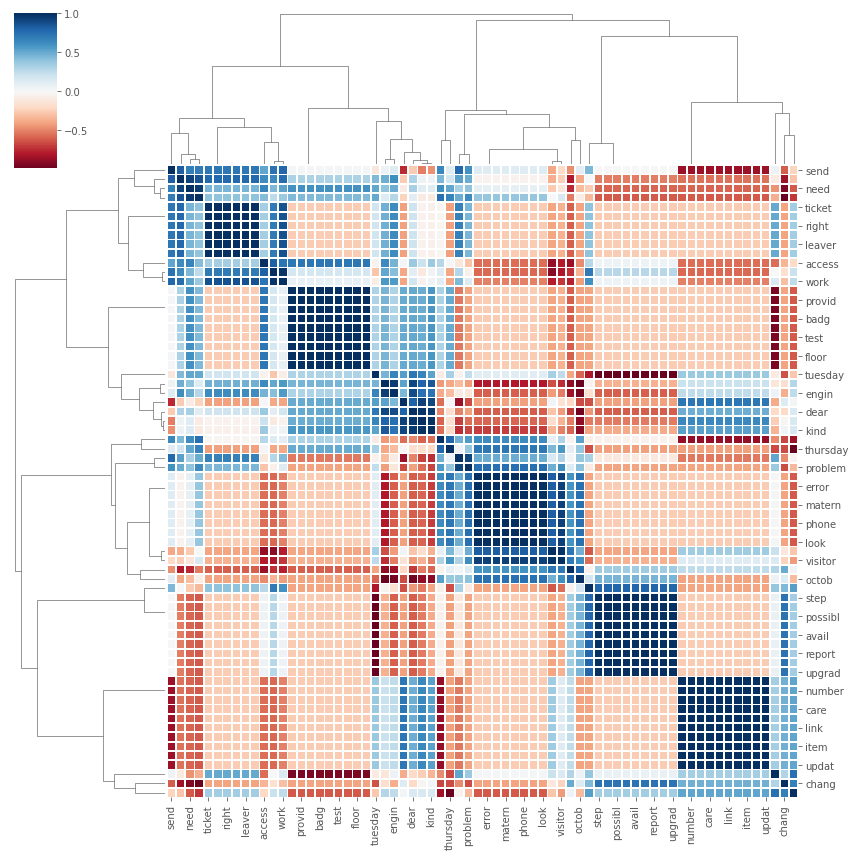

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

g=sns.clustermap(df_lda.corr(), center=0, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

Desde Topic Modeling llegamos a la conclusión de que todo el conjunto de datos se puede dividir en 5 categorías: 

    Network
    User Maintenance
    Database
    Application Workbench
    Security
    
Luego, etiquetamos nuestro conjunto de datos en consecuencia y preparamos un conjunto de datos para realizar un aprendizaje supervisado en él.

Proceso de tockenización de las descripciones que estan en data.Description.values y quedaran en post_seq_padded

In [ ]:
MAX_LENGTH = 500
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.Description.values)
print(data.Description.values)
post_seq = tokenizer.texts_to_sequences(data.Description.values)
post_seq_padded = pad_sequences(post_seq, maxlen=MAX_LENGTH)


['hi since recruiter lead permission approve requisitions makes please make thanks recruiter'
 're expire days hi ask help update passwords colleagues thank pm expire days importance high hi received about expiration please kindly help prolongation best regards pm expire days importance high dear expire days order change please follow steps prerequisites disable device credentials close active connected by cable machine note also follow steps detailed press ctrl alt delete same pops change item enter format enter enter newly chosen then re enter again submit displaying has changed os machine browse enter format enter gear icon top tight browser window enter enter newly chosen then re enter again save connected note complete resources granted once connected by cable browse tick want change after logging enter format enter log enter enter newly chosen then re enter again change clients suppliers about expire please touch person then communicate back encounter issues hesitate by accessing

Resultado de tockenizar el primer elemento de la lista 
print(post_seq_padded[0])

In [ ]:
print(post_seq_padded[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(post_seq_padded, y, test_size=0.05,random_state=42)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

# Deep Learning Model Simple

Selección y entrenamiento de modelos:
RNN para clasificación: -
Una canalización de clasificación de texto de un extremo a otro se compone de los siguientes componentes:
1. Texto de entrenamiento: Es el texto de entrada a través del cual nuestro modelo de aprendizaje supervisado es capaz de aprender y predecir la clase requerida.
2. Vector de características: un vector de características es un vector que contiene información que describe las características de los datos de entrada.
3. Etiquetas: Estas son las categorías/clases predefinidas que nuestro modelo predecirá
4. ML Algo: Es el algoritmo a través del cual nuestro modelo es capaz de lidiar con la clasificación de texto (En nuestro caso: CNN, RNN, HAN)
5. Modelo predictivo: un modelo que se entrena en el conjunto de datos históricos que puede realizar predicciones de etiquetas.

In [ ]:
inputs = Input(shape=(MAX_LENGTH, ))
embedding_layer = Embedding(vocab_size,
                            128,
                            input_length=MAX_LENGTH)(inputs)
x = Flatten()(embedding_layer)
x = Dense(32, activation='relu')(x)

predictions = Dense(num_class, activation='softmax')(x)
model = Model(inputs=[inputs], outputs=predictions)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.summary()
filepath="weights-simple.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit([X_train], batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
          shuffle=True, epochs=10, callbacks=[checkpointer])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 128)          653312    
                                                                 
 flatten (Flatten)           (None, 64000)             0         
                                                                 
 dense (Dense)               (None, 32)                2048032   
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 2,701,509
Trainable params: 2,701,509
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
33/34 [============================>.] -

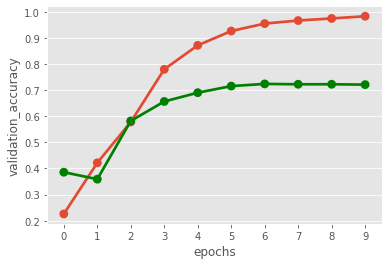

In [ ]:
df = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
g = sns.pointplot(x="epochs", y="accuracy", data=df, fit_reg=False)
g = sns.pointplot(x="epochs", y="validation_accuracy", data=df, fit_reg=False, color='green')

In [ ]:
predicted = model.predict(X_test)
print(X_test[0], predicted[0])
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test, predicted)


[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

0.74

# RNN

Clasificación de incidentes utilizando la red neuronal recurrente (RNN):
Una red neuronal recurrente (RNN) es una clase de red neuronal artificial donde las conexiones entre nodos forman un gráfico dirigido a lo largo de una secuencia. Esto le permite exhibir un comportamiento temporal dinámico durante una secuencia de tiempo.
Usar el conocimiento de una incrustación externa puede mejorar la precisión de su RNN porque integra nueva información (léxica y semántica) sobre las palabras, una información que ha sido entrenada y destilada en un corpus de datos muy grande. utilizado es GloVe.
RNN es una secuencia de bloques de redes neuronales que están vinculados entre sí como una cadena. Cada uno está pasando un mensaje a un sucesor.

In [ ]:
inputs = Input(shape=(MAX_LENGTH, ))
embedding_layer = Embedding(vocab_size,
                            128,
                            input_length=MAX_LENGTH)(inputs)

x = LSTM(64)(embedding_layer)
x = Dense(32, activation='relu')(x)
predictions = Dense(num_class, activation='softmax')(x)
model_lstm = Model(inputs=[inputs], outputs=predictions)
model_lstm.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

model_lstm.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 500, 128)          653312    
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 5)                 165       
                                                                 
Total params: 704,965
Trainable params: 704,965
Non-trainable params: 0
_________________________________________________________________


In [ ]:
filepath="weights.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model_lstm.fit([X_train], batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
          shuffle=True, epochs=20, callbacks=[checkpointer])

Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.5570 - acc: 0.3482
Epoch 1: val_acc improved from -inf to 0.33100, saving model to weights.hdf5
34/34 [==============================] - 24s 663ms/step - loss: 1.5570 - acc: 0.3482 - val_loss: 1.4453 - val_acc: 0.3310
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.2145 - acc: 0.5339
Epoch 2: val_acc improved from 0.33100 to 0.54278, saving model to weights.hdf5
34/34 [==============================] - 17s 510ms/step - loss: 1.2145 - acc: 0.5339 - val_loss: 1.1171 - val_acc: 0.5428
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.8487 - acc: 0.7024
Epoch 3: val_acc improved from 0.54278 to 0.65077, saving model to weights.hdf5
34/34 [==============================] - 12s 358ms/step - loss: 0.8487 - acc: 0.7024 - val_loss: 0.9481 - val_acc: 0.6508
Epoch 4/20
34/34 [==============================] - ETA: 0s - loss: 0.5475 - acc: 0.8273
Epoch 4: val_acc improved from 0.65077 to

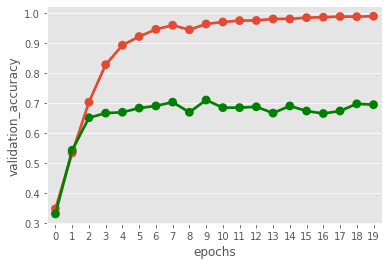

In [ ]:
df = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
g = sns.pointplot(x="epochs", y="accuracy", data=df, fit_reg=False)
g = sns.pointplot(x="epochs", y="validation_accuracy", data=df, fit_reg=False, color='green')

In [ ]:
model_lstm.load_weights('weights.hdf5')

predicted = model_lstm.predict(X_test)


In [ ]:
predicted

array([[1.50447460e-02, 5.95642254e-02, 1.90781429e-02, 6.83626756e-02,
        8.37950170e-01],
       [9.97592390e-01, 1.84484030e-04, 2.01239949e-04, 2.07234989e-05,
        2.00120639e-03],
       [2.11804290e-03, 5.11824200e-03, 1.16495918e-02, 2.56945193e-01,
        7.24168956e-01],
       [2.20446638e-03, 6.60794601e-03, 1.16216592e-01, 2.45684922e-01,
        6.29286051e-01],
       [3.67613598e-06, 2.67363765e-04, 4.88865189e-03, 9.94569957e-01,
        2.70377117e-04],
       [2.33861545e-04, 9.77076709e-01, 2.14010626e-02, 9.90140135e-04,
        2.98206607e-04],
       [1.18051264e-02, 1.18487712e-03, 1.26944541e-03, 5.69283124e-03,
        9.80047762e-01],
       [4.02095793e-07, 5.89397860e-05, 1.84319593e-04, 9.99375880e-01,
        3.80469282e-04],
       [1.62885422e-04, 2.12257146e-03, 9.90351856e-01, 6.51505031e-03,
        8.47522228e-04],
       [1.39254298e-05, 2.38268054e-04, 9.96712565e-01, 2.87025818e-03,
        1.64961617e-04],
       [4.85719397e-07, 6.1990

In [ ]:
predicted = np.argmax(predicted, axis=1)

In [ ]:
accuracy_score(y_test, predicted)

0.7066666666666667

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.71      0.63      0.67        35
           1       0.64      0.78      0.70        27
           2       0.62      0.54      0.58        28
           3       0.77      0.79      0.78        29
           4       0.78      0.81      0.79        31

    accuracy                           0.71       150
   macro avg       0.70      0.71      0.70       150
weighted avg       0.71      0.71      0.70       150



In [ ]:
print(y_test, predicted)

[4 2 3 0 2 2 4 3 0 2 3 0 1 4 1 2 2 0 1 2 0 0 2 3 4 1 2 4 0 4 2 4 1 1 0 1 3
 0 0 4 0 0 0 1 4 4 2 0 2 4 2 3 0 2 0 1 4 1 2 2 1 1 1 0 0 2 4 4 4 0 4 2 1 3
 0 1 3 1 3 2 3 3 1 3 3 0 2 4 2 1 0 4 2 4 4 0 2 3 0 4 3 0 1 4 4 1 3 0 0 4 1
 0 1 3 0 3 0 0 4 3 1 4 1 4 2 3 3 1 1 2 3 4 3 4 2 0 0 4 2 3 2 4 3 1 3 0 3 3
 3 0] [4 0 4 4 3 1 4 3 2 2 3 0 1 0 1 2 2 1 1 1 2 0 2 3 0 1 2 4 0 4 2 3 1 1 0 1 3
 4 0 4 0 4 0 1 4 4 3 0 0 4 2 3 0 2 1 1 4 0 2 1 1 0 1 0 0 2 4 0 4 0 4 2 1 3
 2 1 3 1 3 2 2 2 1 4 3 0 1 4 1 1 0 4 1 0 4 0 1 3 0 4 3 1 1 4 4 2 3 2 2 4 3
 0 1 3 4 3 0 0 4 3 1 3 1 4 0 3 3 2 1 2 1 4 4 4 1 0 3 4 2 3 2 4 3 3 3 0 3 3
 3 0]


In [ ]:
print(X_test[30])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import itertools

In [ ]:
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

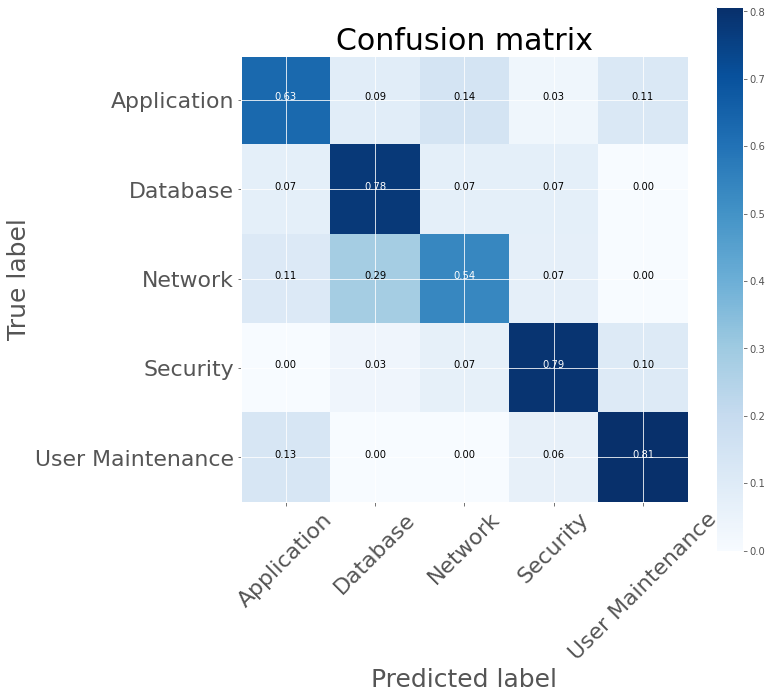

In [ ]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(data.Category.values)
text_labels = encoder.classes_ 
cnf_matrix = confusion_matrix(y_test, predicted)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts("hi since recruiter lead permission approve requisitions makes please make thanks recruiter		")
post_seq = tokenizer.texts_to_sequences("hi since recruiter lead permission approve requisitions makes please make thanks recruiter	")
post_seq_padded = pad_sequences(post_seq, maxlen=MAX_LENGTH)

print(post_seq_padded[0])

predicted = model_lstm.predict(post_seq_padded)
print(predicted[0])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0